In [1]:
!pip install torchview

In [2]:
!pip install graphviz

In [3]:
import pandas as pd
from torch import nn
import torch
from torchinfo import summary
import glob
from tqdm.notebook import tqdm
from PIL import Image 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn 
import random
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose,Resize,RandomVerticalFlip,RandomHorizontalFlip,ColorJitter,ToTensor
from collections import OrderedDict
from sklearn.metrics import confusion_matrix
from seaborn import heatmap

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
#parameters
IMG_WIDTH=224
IMG_HEIGHT=224
BATCH_SIZE = (
        32 if torch.cuda.device_count() < 2 
        else (32 * torch.cuda.device_count())
    )
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
NUM_DEVICES = torch.cuda.device_count()
LR = 1e-4
PATIENCE=8
EPOCHS=100
PATH_TO_DATASET='/kaggle/input/lgg-mri-segmentation/kaggle_3m'
PATH_TO_CSV='/kaggle/input/lgg-mri-segmentation/kaggle_3m/data.csv'

In [5]:
DEVICE

'cuda'

In [6]:
NUM_DEVICES

2

In [7]:
def read_data_csv(path):
    data_csv=pd.read_csv(path)
    data=pd.DataFrame(data_csv)
    print(f'Data {data.head()}')

In [8]:
def create_dataframe():
    #read path for images
    datasets_path=glob.glob(f'{PATH_TO_DATASET}/*/*.tif')
    masks_path=glob.glob(f'{PATH_TO_DATASET}/*/*mask.tif')
    images_path=[mask_path.split('_mask.tif')[0]+'.tif' for mask_path in masks_path]
    patients_id=[]
    labels=[]
    for path in masks_path:
#         if path not in masks_path:
#             images_path.append(path)
            patients_id.append(path.split('/')[-2])
            labels.append( generate_label(path))
    print(f'Length of images path {len(images_path)}, length of masks path {len(masks_path)}, length of patients id {len(patients_id)}, length of labels {len(labels)}')
    data=pd.DataFrame(data={
        'patient_id':patients_id,
        'image path':images_path,
        'mask path':masks_path,
        'label':labels
    })
    print(data.head())
    return data






In [9]:
def generate_label(path:str):
    img=Image.open(path)
    img_array=np.array(img).astype(np.float32) / 255
    if img_array.max()>0:
        return 1
    else:
        return 0
    

In [10]:
def view_sample(index:int,data):
    label=data['label'][index]
    path_img=data['image path'][index]
    path_mask=data['mask path'][index]
    print(f'Path for image {path_img}, path for mask {path_mask}, label {label}')
    
    #3chart 1-img,2-mask,3-img+mask
    img=Image.open(path_img)
    img_array=np.array(img).astype(np.float32) / 255
    plt.subplot(1,3,1)
    plt.title(f'Image of brain')
    plt.imshow(img_array,cmap='mako')
    
    mask=Image.open(path_mask)
    mask_array=np.array(mask).astype(np.float32) / 255
    plt.subplot(1,3,2)
    plt.title(f'Mask,label ={data["label"][index]}')
    plt.imshow(mask_array,cmap='gray')
    
    plt.subplot(1,3,3)
    plt.imshow(img_array,cmap='mako')
    plt.title(f'Image of brain and mask ')
    plt.imshow(mask_array,cmap='gray',alpha=0.5)

Data         Patient  RNASeqCluster  MethylationCluster  miRNACluster  CNCluster  \
0  TCGA_CS_4941            2.0                 4.0             2        2.0   
1  TCGA_CS_4942            1.0                 5.0             2        1.0   
2  TCGA_CS_4943            1.0                 5.0             2        1.0   
3  TCGA_CS_4944            NaN                 5.0             2        1.0   
4  TCGA_CS_5393            4.0                 5.0             2        1.0   

   RPPACluster  OncosignCluster  COCCluster  histological_type  \
0          NaN              3.0           2                1.0   
1          1.0              2.0           1                1.0   
2          2.0              2.0           1                1.0   
3          2.0              1.0           1                1.0   
4          2.0              3.0           1                1.0   

   neoplasm_histologic_grade  tumor_tissue_site  laterality  tumor_location  \
0                        2.0                

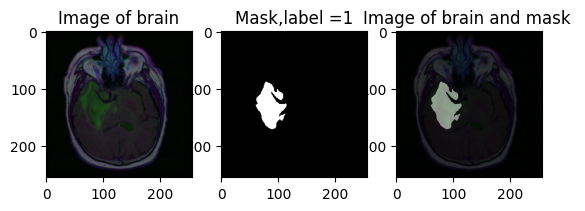

In [11]:
#read data from csv
read_data_csv(path=PATH_TO_CSV)
data=create_dataframe()
index=random.randint(0,len(data['label']))
view_sample(index=index,data=data)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_10.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_7300_19910814/TCGA_DU_7300_19910814_10_mask.tif, label 0


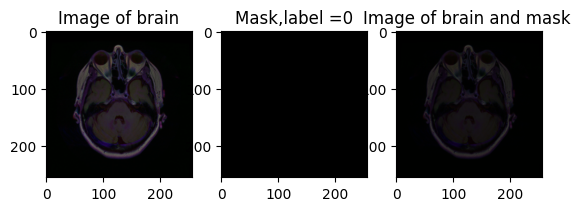

In [12]:
index=random.randint(0,len(data['label']))
view_sample(index=index,data=data)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_31.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5851_19950428/TCGA_DU_5851_19950428_31_mask.tif, label 0


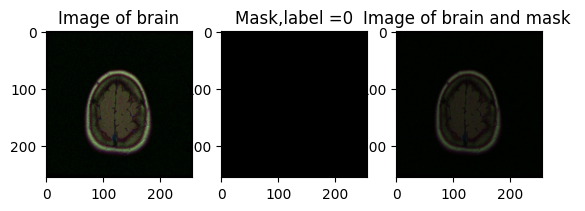

In [14]:
index=random.randint(0,len(data['label']))
view_sample(index=index,data=data)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_37.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_6400_19830518/TCGA_DU_6400_19830518_37_mask.tif, label 0


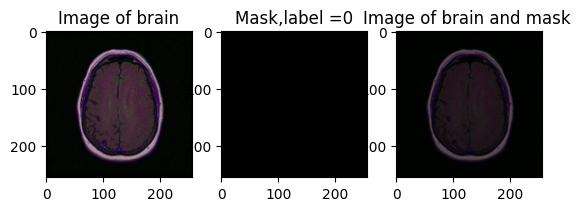

In [15]:
index=random.randint(0,len(data['label']))
view_sample(index=index,data=data)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_32.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_FG_6688_20020215/TCGA_FG_6688_20020215_32_mask.tif, label 1


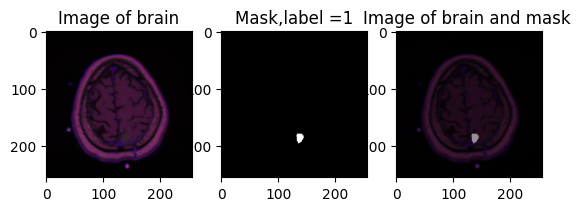

In [16]:
index=random.randint(0,len(data['label']))
view_sample(index=index,data=data)

[[2556], [1373]]


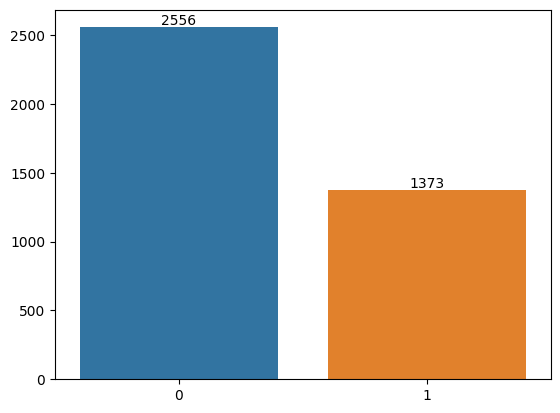

In [15]:
cancer=len(data[data['label']==1])
no_cancer=len(data[data['label']==0])
data_cancer=[[no_cancer],[cancer]]
print(data_cancer)
ax = seaborn.barplot(data=data_cancer)
for i in ax.containers:
    ax.bar_label(i,)

In [17]:
#Create training,validate,test sets
X_train, X_test, y_train, y_test = train_test_split(data.index,data.label, test_size=0.2,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.2,random_state=42)

In [18]:
print(f'Train dataset {len(X_train)} {len(y_train)}, validate dataset {len(X_val)} {len(y_val)}, test dataset {len(X_test)} {len(y_test)}')

Train dataset 2514 2514, validate dataset 629 629, test dataset 786 786


In [19]:
#create training DataFrame
images_test=[]
masks_test=[]
patients_id_test=[]
images_val=[]
masks_val=[]
patients_id_val=[]
images_train=[]
masks_train=[]
patients_id_train=[]

for idx in X_val:
    images_val.append(data['image path'][idx])
    masks_val.append(data['mask path'][idx])
    patients_id_val.append(data['patient_id'][idx])
    
for idx in X_train:
    images_train.append(data['image path'][idx])
    masks_train.append(data['mask path'][idx])
    patients_id_train.append(data['patient_id'][idx])

for idx in X_test:
    images_test.append(data['image path'][idx])
    masks_test.append(data['mask path'][idx])
    patients_id_test.append(data['patient_id'][idx])
    
data_train=pd.DataFrame(
data={
        'patient_id':patients_id_train,
        'image path':images_train,
        'mask path':masks_train,
        'label':y_train,
    })
data_val=pd.DataFrame(
data={
        'patient_id':patients_id_val,
        'image path':images_val,
        'mask path':masks_val,
        'label':y_val,
    })

data_test=pd.DataFrame(
data={
        'patient_id':patients_id_test,
        'image path':images_test,
        'mask path':masks_test,
        'label':y_test,
    })


[[509], [277]]


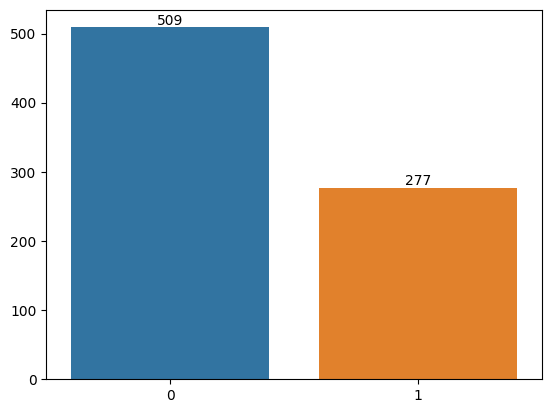

In [21]:
cancer=len(data_test[data_test['label']==1])
no_cancer=len(data_test[data_test['label']==0])
data_cancer=[[no_cancer],[cancer]]
print(data_cancer)
ax = seaborn.barplot(data=data_cancer)
for i in ax.containers:
    ax.bar_label(i,)

[[1640], [874]]


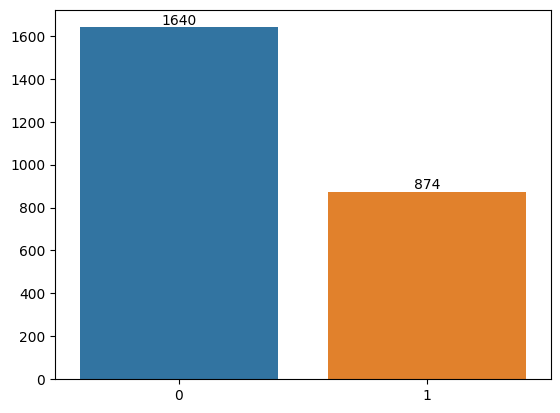

In [22]:
#visualize train, test, validate datasets

cancer=len(data_train[data_train['label']==1])
no_cancer=len(data_train[data_train['label']==0])
data_cancer=[[no_cancer],[cancer]]
print(data_cancer)
ax = seaborn.barplot(data=data_cancer)
for i in ax.containers:
    ax.bar_label(i,)

[[222], [407]]


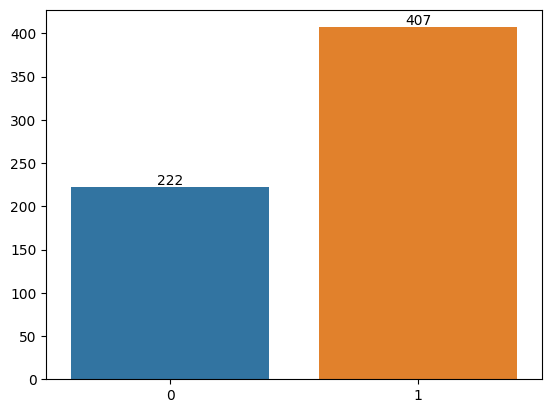

In [23]:
cancer=len(data_val[data_val['label']==1])
no_cancer=len(data_val[data_val['label']==0])
data_cancer=[[cancer],[no_cancer]]
print(data_cancer)
ax = seaborn.barplot(data=data_cancer)
for i in ax.containers:
    ax.bar_label(i,)

In [24]:
print(f'train samples count:\t\t{len(X_train)}\t({(100 * len(X_train)/len(data["label"])):.2f}%)')
print(f'validation samples count:\t{len(X_val)}\t({(100 * len(X_val)/len(data["label"])):.2f}%)')
print(f'test samples count:\t\t{len(X_test)}\t({(100 * len(X_test)/len(data["label"])):.2f}%)')
print('================================================')
print(f'TOTAL:\t\t\t\t{len(data["label"])}\t({(100 * len(data["label"])/len(data["label"])):.2f}%)')

train samples count:		2514	(63.99%)
validation samples count:	629	(16.01%)
test samples count:		786	(20.01%)
TOTAL:				3929	(100.00%)


In [25]:
#Build datasets, dataloaders
#Augmentation data

transform_data=Compose([
    Resize((IMG_WIDTH,IMG_HEIGHT)),
    ColorJitter(brightness=[0.1,1],contrast=[0.1,1]),
    RandomHorizontalFlip(p=0.5),
    RandomVerticalFlip(p=0.5),
    ToTensor(),
])

resize_transform=Compose([
    Resize((IMG_WIDTH,IMG_HEIGHT)),
    ToTensor()
])


In [26]:
class CustomImageDataset(Dataset):
    def __init__(self, data:pd.DataFrame,transform=None):
        self.images = data['image path'].to_list()
        self.masks = data['mask path'].to_list()
        self.labels=data['label'].to_list()
        self.transform = transform
   
    def read_image(self,path:str):
        img=Image.open(path)
#         img_array=np.array(img).astype(np.float32) / 255
        return img

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mask_path = self.masks[idx]
        image = self.read_image(img_path)
        mask = self.read_image(mask_path)
        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)
        return image,mask

In [27]:
train_datasets=CustomImageDataset(data=data_train,transform=resize_transform)
validation_datasets=CustomImageDataset(data=data_val,transform=resize_transform)
test_datasets=CustomImageDataset(data=data_test,transform=resize_transform)

In [28]:
train_dataloader=DataLoader(train_datasets,batch_size=64,shuffle=True)
validation_dataloader=DataLoader(validation_datasets,batch_size=64)
test_dataloader=DataLoader(test_datasets,batch_size=64)

In [29]:
def train(model,dataloader:DataLoader,validate_dataloader:DataLoader,optmizer:torch.optim, loss_fn:nn.Module,device:torch.device):
    train_loss, train_dice = 0, 0
    for batch,(X,y) in enumerate(dataloader):
        model.train()
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        predicted_class = torch.sigmoid(y_pred)
        predicted_class = (predicted_class > 0.5).float()
        
        eps = 1e-8
        train_dice += (
            (2 * (y * predicted_class).sum() + eps) / 
            ((y + predicted_class).sum() + eps)
        ).cpu().item()
        
        
    validate_loss, validate_dice=test(model,validate_dataloader,optimizer,loss_fn,device)
    train_loss = train_loss / len(dataloader)
    train_dice = train_dice / len(dataloader)
    
    return train_loss, train_dice, validate_loss, validate_dice
        

In [30]:
def test(model,dataloader:DataLoader,optmizer:torch.optim, loss_fn:nn.Module,device:torch.device):
    test_loss, test_dice = 0, 0
    model.eval()
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item() 
            predicted_class = torch.sigmoid(y_pred)
            predicted_class = (predicted_class > 0.5).float()

            eps = 1e-8
            test_dice += (
                (2 * (y * predicted_class).sum() + eps) / 
                ((y + predicted_class).sum() + eps)
            ).cpu().item()


        test_loss = test_loss / len(dataloader)
        test_dice = test_dice / len(dataloader)
    
    return test_loss, test_dice

In [31]:
def run(
    model:torch.nn.Module,
    train_dataloader:torch.utils.data.DataLoader,
    validation_dataloader:torch.utils.data.DataLoader,
    test_dataloader:torch.utils.data.DataLoader,
    optimizer:torch.optim.Optimizer,
    scheduler:torch.optim.lr_scheduler,
    loss_fn:torch.nn.Module,
    epochs:int,
    device:torch.device
   ):
    
    training_results = {
        'train_loss'            : [],
        'train_dice_score'      : [],
        'validate_loss'       : [],
        'validate_dice_score' : []
    }
    test_results = {
        'test_loss'            : [],
        'test_dice_score'      : [],
    }
    
    for epoch in tqdm(range(epochs)):
        print(f'\nEpoch {epoch + 1}/{epochs}')
        train_loss, train_dice, validate_loss, validate_dice = train(
            model, 
            train_dataloader, 
            validation_dataloader,
            optimizer, 
            loss_fn, 
            device
        )
        current_lr = 0
        if scheduler: 
            scheduler.step(validate_loss)
            current_lr = optimizer.param_groups[0]['lr']
        
        # Log Epoch Metrics
        log_text = f'loss: {train_loss:.4f} - dice_score: {train_dice} - val_loss: {validate_loss:.4f} - val_dice_score: {validate_dice}'
        
        if scheduler: 
            print(log_text + f' - lr: {current_lr}')
        else:
            print(log_text)
            
        # Record Epoch Metrics
        training_results['train_loss'].append(train_loss)
        training_results['train_dice_score'].append(train_dice)
        training_results['validate_loss'].append(validate_loss)
        training_results['validate_dice_score'].append(validate_dice)
    
    test_loss, test_dice=test(model,test_dataloader,optimizer, loss_fn,device)
    test_results['test_loss'].append(test_loss)
    test_results['test_dice_score'].append(test_dice)
    
    return training_results,test_results

In [13]:
class DoubleConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=3, stride=1, 
            padding=1, bias=False
        )
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 
            kernel_size=3, stride=1, 
            padding=1, bias=False
        )

        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        
        self.relu1 = nn.ReLU(inplace=True)
        self.relu2 = nn.ReLU(inplace=True)
        
        
    def forward(self, x):
        # First Convolution
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu1(x)
        
        # Second Convolution
        x = self.conv2(x)
        x = self.batchnorm2(x)
        
        return self.relu2(x)

In [14]:
class UNetModel(nn.Module):
    def __init__(
        self, in_channels:int=3, 
        out_channels:int=1, 
        block_sizes=(64, 128, 256, 512)
    ):
        super(UNetModel, self).__init__()
        # Initialise model encoder & decoder using torch ModuleLists
        self.encoder, self.decoder = nn.ModuleList(), nn.ModuleList()
        self.max_pool = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Create Encoder
        for block_size in block_sizes:
            self.encoder.append(DoubleConvBlock(in_channels, block_size))
            in_channels = block_size
            
        # Create Decoder
        for block_size in block_sizes[::-1]:
            self.decoder.append(
                nn.ConvTranspose2d(2 * block_size, block_size, kernel_size=2, stride=2)
            )
            self.decoder.append(DoubleConvBlock(2 * block_size, block_size))
        
        # Create Bottleneck
        last_blocksize = block_sizes[-1]
        self.bottleneck = DoubleConvBlock(last_blocksize, 2 * last_blocksize)
        
        # Create Output Layer
        self.output_conv = nn.Conv2d(block_sizes[0], out_channels, kernel_size=1)
        
    def forward(self, x):
        concatenations = []
        concatenations.append(x)
        
        # Propagate input downstream (Encode Input)
        for encoder_layer in self.encoder:
            x = encoder_layer(x)
            concatenations.append(x)
            x = self.max_pool(x)
            
        # Execute bottleneck
        x = self.bottleneck(x)
        concatenations = concatenations[::-1]
        
        # Propagate input upstream (Decode Input) & concatenate layers
        for _ in range(0, len(self.decoder), 2):
            x = self.decoder[_](x)
            encoder_layer = concatenations[_ // 2]
            
            # Concatenate corrensponding encoder layer to decoder layer output
            concat_layer = torch.cat(
                (encoder_layer, x), dim=1
            )
            
            x = self.decoder[_ + 1](concat_layer)
            
        # Return predicted logits    
        return self.output_conv(x)

In [15]:
# Define U-Net Params
unet_params = {
    'in_channels'    : 3,
    'out_channels'   : 1,
    'block_sizes'    : (64, 128, 256, 512)
}


unet_model = UNetModel(**unet_params).to(DEVICE)
if NUM_DEVICES > 1:
    unet_model = nn.DataParallel(unet_model)
summary(
    model=unet_model, 
    input_size=(BATCH_SIZE, 3, IMG_WIDTH, IMG_HEIGHT),
    col_names=["output_size", "num_params", "trainable"],
    col_width=20,
    row_settings=["var_names"]
)

Layer (type (var_name))                       Output Shape         Param #              Trainable
DataParallel (DataParallel)                   [64, 1, 224, 224]    --                   True
├─UNetModel (module)                          [32, 1, 224, 224]    31,037,633           True
├─UNetModel (module)                          --                   (recursive)          True
│    └─ModuleList (encoder)                   --                   (recursive)          True
│    │    └─DoubleConvBlock (0)               [32, 64, 224, 224]   38,848               True
│    │    └─DoubleConvBlock (0)               --                   (recursive)          True
├─UNetModel (module)                          [32, 1, 224, 224]    --                   --
├─UNetModel (module)                          --                   (recursive)          True
│    └─ModuleList (encoder)                   --                   (recursive)          True
│    │    └─DoubleConvBlock (0)               [32, 64, 224, 224]   

In [16]:


loss_fn = nn.BCEWithLogitsLoss()


optimizer = torch.optim.AdamW(
    unet_model.parameters(),
    lr=LR
)

# Define Scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer=optimizer, 
    mode='min',
    patience=PATIENCE,
    verbose=True
)

In [36]:
print('Training U-Net Model')
print(f'Train on {len(train_datasets)} samples, validate on {len(validation_datasets)} samples, test on {len(test_datasets)}')
print('----------------------------------')

configs = {
    'model': unet_model,
    'train_dataloader': train_dataloader,
    'validation_dataloader': validation_dataloader,
    'test_dataloader': test_dataloader,
    'optimizer': optimizer,
    'scheduler': scheduler, 
    'loss_fn': loss_fn,
    'epochs':EPOCHS,
    'device':DEVICE
}

training_results,test_results = run(**configs)

Training U-Net Model
Train on 2514 samples, validate on 629 samples, test on 786
----------------------------------


  0%|          | 0/100 [00:00<?, ?it/s]


Epoch 1/100
loss: 0.4642 - dice_score: 0.29201506534591315 - val_loss: 0.3758 - val_dice_score: 3.2679965369019835e-13 - lr: 0.0001

Epoch 2/100
loss: 0.3185 - dice_score: 0.4691486366093159 - val_loss: 0.3034 - val_dice_score: 0.6094389796257019 - lr: 0.0001

Epoch 3/100
loss: 0.2834 - dice_score: 0.5501091726124286 - val_loss: 0.2735 - val_dice_score: 0.5558000773191452 - lr: 0.0001

Epoch 4/100
loss: 0.2615 - dice_score: 0.5938569985330104 - val_loss: 0.2577 - val_dice_score: 0.664842712879181 - lr: 0.0001

Epoch 5/100
loss: 0.2424 - dice_score: 0.6522809267044067 - val_loss: 0.2328 - val_dice_score: 0.596089631319046 - lr: 0.0001

Epoch 6/100
loss: 0.2259 - dice_score: 0.6550930000841617 - val_loss: 0.2232 - val_dice_score: 0.6782151758670807 - lr: 0.0001

Epoch 7/100
loss: 0.2102 - dice_score: 0.6995412349700928 - val_loss: 0.2014 - val_dice_score: 0.5749349504709244 - lr: 0.0001

Epoch 8/100
loss: 0.1964 - dice_score: 0.7357331231236458 - val_loss: 0.1880 - val_dice_score: 0.741

In [ ]:
results_data=pd.DataFrame({
    'train_loss' training_results['train_loss'],
    'validate_loss'training_results['validate_loss'],
    'test_loss' test_results['test_loss'],
    'train_dice_score'training_results['train_dice_score'],
    'validate_dice_score'training_results['validate_dice_score'],
    'test_dice_score' test_results['test_dice_score'],
})

results_data.to_csv('/kaggle/working/results.csv')

In [ ]:
# checkpoint = {'model': unet_model,
#               'state_dict': unet_model.state_dict(),
#               'optimizer' : optimizer.state_dict()}

torch.save(unet_model, 'model1.pth')
torch.save(unet_model.state_dict(), 'model_state_dict1.pth')

In [ ]:
unet_model.state_dict()

In [ ]:
import os
import subprocess
from IPython.display import FileLink, display

def download_file(path, download_file_name):
    os.chdir('/kaggle/working/')
    zip_name = f"/kaggle/working/{download_file_name}.zip"
    command = f"zip {zip_name} {path} -r"
    result = subprocess.run(command, shell=True, capture_output=True, text=True)
    if result.returncode != 0:
        print("Unable to run zip command!")
        print(result.stderr)
        return
    display(FileLink(f'{download_file_name}.zip'))

In [ ]:
download_file('/kaggle/working/model.pth', 'model')
download_file('/kaggle/working/model_state_dict.pth', 'model_state_dict')
download_file('/kaggle/working/results.csv', 'results')

In [17]:
unet_params = {
    'in_channels'    : 3,
    'out_channels'   : 1,
    'block_sizes'    : (64, 128, 256, 512)
}


In [18]:
unet_model = UNetModel(**unet_params).to(DEVICE)
model_unet=torch.load('/kaggle/input/model-resnet/model.pth')
state_dict=model_unet.state_dict()
new_state_dict = OrderedDict()
for key, value in state_dict.items():
    new_key=key.replace('module.','')
    new_state_dict[new_key]=value
    

unet_model.load_state_dict(new_state_dict)
torch.save(unet_model.state_dict(), 'model_state_dict1.pth')
if NUM_DEVICES > 1:
    unet_model = nn.DataParallel(unet_model)

In [117]:

def view_predictions(index,data,device):
    label=data['label'][index]
    path_img=data['image path'][index]
    path_mask=data['mask path'][index]
    print(f'Path for image {path_img}, path for mask {path_mask}, label {label}')
    
    predicted_mask,predicted_class,predicted_label=predict(path_img,path_mask,label,device)

    
    #3charts 1-img,2-mask,3-img+mask
    img=Image.open(path_img)
    img_array=np.array(img).astype(np.float32) / 255
    plt.subplot(2,3,1)
    plt.title(f'Image of brain')
    plt.imshow(img_array,cmap='mako')
    
    mask=Image.open(path_mask)
    mask_array=np.array(mask).astype(np.float32) / 255
    plt.subplot(2,3,2)
    plt.title(f'Mask,label ={data["label"][index]}')
    plt.imshow(mask_array,cmap='gray')
    
    plt.subplot(2,3,3)
    plt.imshow(img_array,cmap='mako')
    plt.title(f'Image of brain and mask ')
    plt.imshow(mask_array,cmap='gray',alpha=0.5)
    
    
    img=Image.open(path_img)
    img_array=np.array(img).astype(np.float32) / 255
    plt.subplot(2,3,4)
    plt.title(f'Image of brain')
    plt.imshow(img_array,cmap='mako')
    
 
    plt.subplot(2,3,5)
    plt.title(f'Pred mask')
    plt.imshow(predicted_mask,cmap='gray')
    
    plt.subplot(2,3,6)
    plt.imshow(img_array,cmap='mako')
    plt.title(f'Img,pred mask,pred class={predicted_label} ')
    plt.imshow(predicted_mask,cmap='gray',alpha=0.5)
    

    
def predict(path_img,path_mask,label,device):
    test_loss=0
    test_dice=0
    X=Image.open(path_img)
    y=Image.open(path_mask)
    print(X.size,y.size)
    X=torch.Tensor(np.array(X)).permute(2,0,1).unsqueeze(0)
    y=torch.Tensor(np.array(y))
    print(f'Image shape {X.shape} mask shape {y.shape}')
#     mri_input = torch.tensor(image)
    with torch.inference_mode():
        X, y = X.to(device), y.to(device)
        y_pred = unet_model(X)[0][0]
        print('Y pred shape',y_pred.shape)
        loss = loss_fn(y_pred, y)
        test_loss += loss.item() 
        predicted_class = torch.sigmoid(y_pred)
        predicted_class = (predicted_class > 0.3).float()
        if predicted_class.max()>0:
            predicted_label=1
        else:
            predicted_label=0

        eps = 1e-8
        test_dice += (
                (2 * (y * predicted_class).sum() + eps) / 
                ((y + predicted_class).sum() + eps)
        ).cpu().item()
        
        
#         img=unet_model(image)
#         predicted_class = torch.sigmoid(img)
#         if predicted_class.max()>0:
#             predicted_class=1
#         else:
#             predicted_class=0
#         img=img.cpu()
        return y_pred.cpu(),predicted_class.cpu(),predicted_label

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_33.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_33_mask.tif, label 1
(256, 256) (256, 256)
Image shape torch.Size([1, 3, 256, 256]) mask shape torch.Size([256, 256])
Y pred shape torch.Size([256, 256])


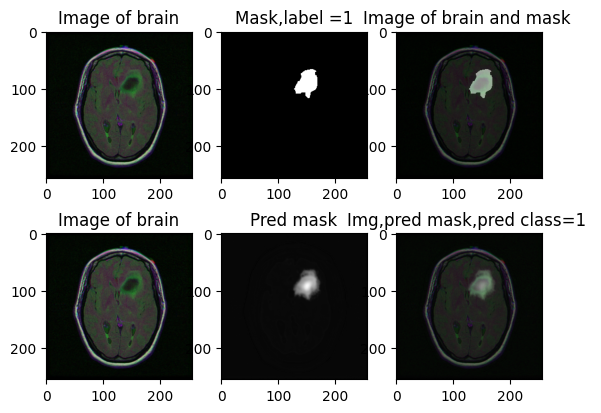

In [127]:
index=random.randint(0,len(data['label']))
view_predictions(index=index,data=data,device=DEVICE)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_18.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_CS_4943_20000902/TCGA_CS_4943_20000902_18_mask.tif, label 1
(256, 256) (256, 256)
Image shape torch.Size([1, 3, 256, 256]) mask shape torch.Size([256, 256])
Y pred shape torch.Size([256, 256])


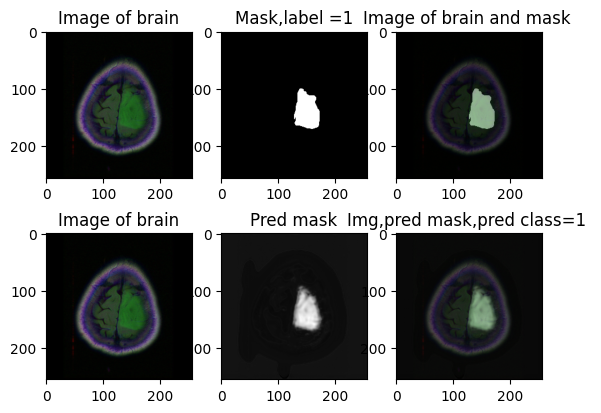

In [129]:
index=random.randint(0,len(data['label']))
view_predictions(index=index,data=data,device=DEVICE)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_49.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_A5TT_19980318/TCGA_DU_A5TT_19980318_49_mask.tif, label 1
(256, 256) (256, 256)
Image shape torch.Size([1, 3, 256, 256]) mask shape torch.Size([256, 256])
Y pred shape torch.Size([256, 256])


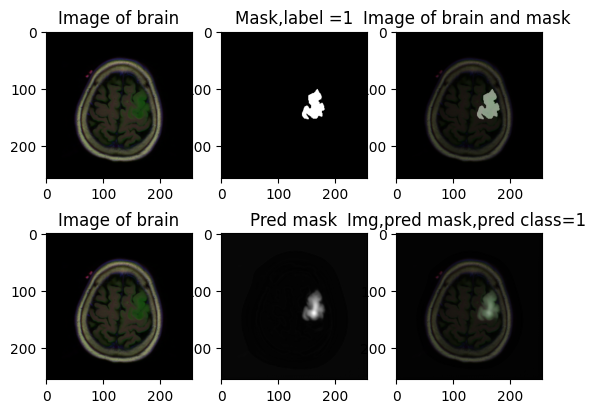

In [134]:
index=random.randint(0,len(data['label']))
view_predictions(index=index,data=data,device=DEVICE)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_DU_5872_19950223/TCGA_DU_5872_19950223_46_mask.tif, label 1
(256, 256) (256, 256)
Image shape torch.Size([1, 3, 256, 256]) mask shape torch.Size([256, 256])
Y pred shape torch.Size([256, 256])


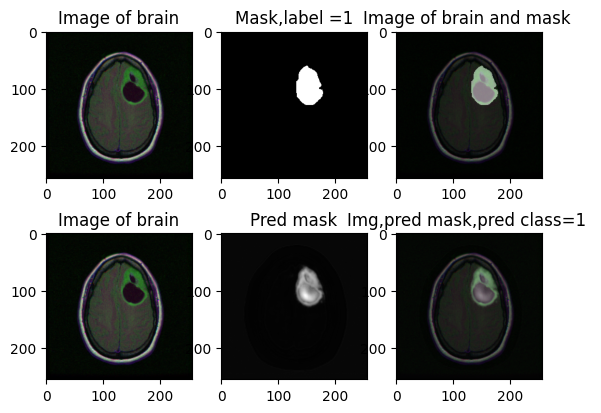

In [137]:
index=random.randint(0,len(data['label']))
view_predictions(index=index,data=data,device=DEVICE)

Path for image /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_23.tif, path for mask /kaggle/input/lgg-mri-segmentation/kaggle_3m/TCGA_HT_7605_19950916/TCGA_HT_7605_19950916_23_mask.tif, label 1
(256, 256) (256, 256)
Image shape torch.Size([1, 3, 256, 256]) mask shape torch.Size([256, 256])
Y pred shape torch.Size([256, 256])


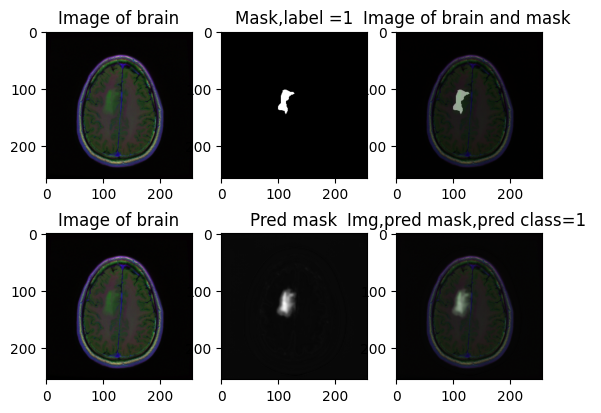

In [136]:
index=random.randint(0,len(data['label']))
view_predictions(index=index,data=data,device=DEVICE)

In [ ]:
#metrics

#plot loss
    
plt.subplot(2,1,1)
plt.plot(training_results['train_loss'],label='train')
plt.plot(training_results['validate_loss'],label='validate')
plt.plot(test_results['test_loss'],label='test')
plt.title('Loss functions')
plt.legend() 
plt.savefig('loss.png')
plt.subplot(2,1,2)
plt.plot(training_results['train_dice_score'],label='train')
plt.plot(training_results['validate_dice_score'],label='validate')
plt.plot(test_results['test_lice_score'],label='test')
plt.title('Dice_score')
plt.legend() 
plt.savefig('dice_score.png')
    